----
### This note is from *The 12th Computational Neuroscience Winter School @ SJTU* and supplemented by me.
----

This notebook includes the history of the development of artificial intelligence in the last century. Some classical models and algorithms with some interesting examples as exercises are shown.

- MP Model
- Hebbian Learning
- Hopfield Model

---
# Setup


---

In [1]:
# Import most modules and functions needed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from scipy.stats import chi2
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelweight'] = 'bold'
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

---
# Section 1: MP Model

*Reference:* 

*McCulloch, W.S., & Pitts, W.H. (1943). A logical calculus of the ideas immanent in nervous activity. Bulletin of Mathematical Biology, 52, 99-115.*

---

Warren S. Mcculloch and Walter Pitts (1943) found that single neuron can do logical operations. Based on this fact, they proposed a kind of computational model that performs like a neuron.

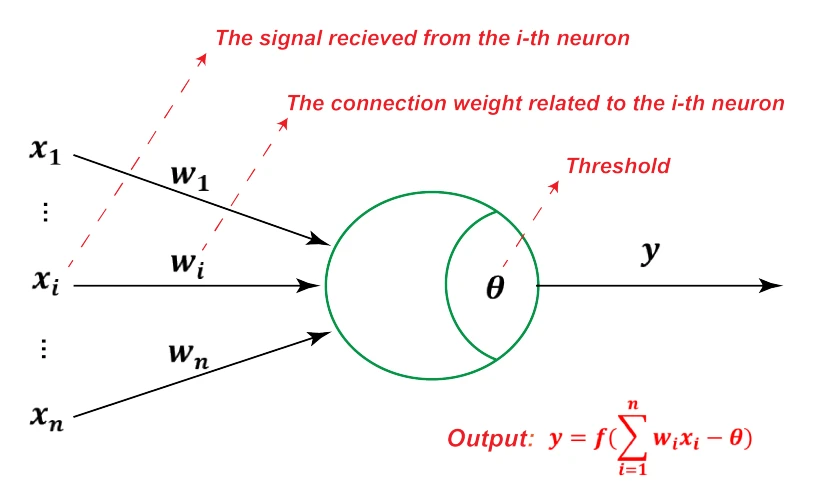

MP Model can be used to do binary classification (Actually, MP model can be seen as linear classifier), since the output of the model is boolean. Here we take Wiscosin dataset as an example. Wiscosin dataset is a dataset for breast cancer, which contains 30 features about the tumor, and you need to classify that which is malignant and which is benign. 


#### Wiscosin dataset

In [2]:
# Load wiscosin dataset
breast_cancer = sklearn.datasets.load_breast_cancer()

X = breast_cancer.data
Y = breast_cancer.target
data = pd.DataFrame(breast_cancer.data,columns=breast_cancer.feature_names)
data['class'] = breast_cancer.target

data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


#### Spliting the data to training set and test set

In [3]:
X = data.drop('class',axis=1)
Y = data['class']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, stratify=Y, random_state=0)


X_binarise_train = X_train.apply(pd.cut, bins=2, labels=[1,0])
X_binarise_test = X_test.apply(pd.cut, bins=2, labels=[1,0])


X_binarise_train = X_binarise_train.values
X_binarise_test = X_binarise_test.values


print('Target: ',Y.mean(), Y_train.mean(), Y_test.mean())

Target:  0.6274165202108963 0.626953125 0.631578947368421


#### Constrcut MP neuron
 
We should note that there didn't exist an training algorithm for us to find out $w$, so here we would fix all the weight to $1$, and try to search a best $\theta=b$ for classification. The input-output relation becomes:
$$\hat y_i=\Theta(\sum_{j}^n x_i^j-b)$$
Since there are totally $n$ features, here we investigate the best integer threshold between $[0,n]$

In [4]:
class MPNeuron:
    def __init__(self):
        self.b = None
    
    def model(self,x):
        # Output of the model, if sum x_i >= b, then output would be 1(True), otherwise 0(False).
        return (sum(x) >= self.b)
    
    def predict(self,X):
        Y = []
        for x in X:
            Y.append(self.model(x))
        return np.array(Y)
    
    def fit(self,X,Y):
        accuracy = {}
        for b in range(X.shape[1] + 1):
            self.b = b
            Y_pred = self.predict(X)
            accuracy[b] = accuracy_score(Y_pred,Y)
            
        best_b = max(accuracy, key = accuracy.get)
        self.b = best_b
        
        print('Best train accuracy: {:.2f}'.format(accuracy[best_b]))

        
mp_neuron = MPNeuron()
mp_neuron.fit(X_binarise_train,Y_train)

w = mp_neuron.predict(X_binarise_test)
print('Test accuracy: {:.2f}'.format(accuracy_score(w,Y_test)))

Best train accuracy: 0.86
Test accuracy: 0.74


---
# Section 2: Hebbian Learning

*Reference:* 

*Hebb, D.O. (1949). The Organization of Behavior: A Neuropsychological Theory.*

---

Hebb's rule: "Fire together, wire together." Consider using Hebb's rule in the MP model:

$$
y(x)=\Theta(w^Tx-\theta)
$$

then, a sequence of inputs $(x_i)_{i=1}^n$ are given to the model, the weights would updates as

$$
w_{t+1}=w_{t}+\eta y(x_i)x_i
$$

So Hebbian learning is an algorithm for unsupervised learning. If we consider a simplified MP model:

$$y(x)=w^Tx$$

And we update the weight only when the model has seen all data, then the updating rule becomes:

$$w_{t+1}=w_{t}+\eta \sum_{i=1}^ny(x_i)x_i=(I+\eta \sum_{i=1}^n x_ix_i^T)w_{t}$$

Note: $y(x_i)x_i = w^T x_i x_i = x_i (w^T x_i) = x_i (w^T x_i)^T = x_i (x_i^T w) = x_i x_i^T w$

Note: 矩阵相乘有个前提：当矩阵A的列数（column）等于矩阵B的行数（row）时，A与B可以相乘。所以对于列向量$w$和$x$，我们会发现$w^Txx≠w^T(xx)$，这并不是因为矩阵的乘法结合律（$(AB)C=A(BC)$）失效了，而是矩阵相乘的前提被破坏了，只要矩阵能相乘结合律就一定满足，这里是由于$x$是列向量，自己无法和自己相乘，导致这种情况是因为行向量和列向量相乘是标量，或者说我们可以把一个标量拆成两个维度相同的两个行向量和列向量相乘，而所得到的行、列向量并不一定可以和前后的矩阵相乘，如果不可以和前后矩阵相乘，就不能用结合律了。在上面的note中，通过对标量$w^T x_i$的位置的调整实现可以顺利使用矩阵乘法结合律。

So we have

$$w_{t}=(I+\eta C)^t w_{0}$$

where $C=\sum_{i=1}^n x_ix_i^T$ is the covariance matrix of data. Then we know the weight vector would finally converge to the direction of leading eigenvector of $C$, as long as  the initial iterate has a projection onto the leading eigenvector.

Note: 

The equation is a form of the power iteration method, which is commonly used to compute the leading eigenvector of a matrix. In this case, the matrix is the covariance matrix $C$ and the weight vector is updated iteratively using the equation $w_{t}=(I+\eta C)^t w_{0}$.

The convergence of this iterative method depends on the spectral properties of the matrix $C$, specifically the magnitude of its eigenvalues. It can be shown that the leading eigenvector of $C$ corresponds to the eigenvector with the largest eigenvalue. As $t$ increases, the effect of all other eigenvectors diminishes and the weight vector converges to the direction of the leading eigenvector of $C$.

However, this convergence is only guaranteed if the initial iterate $w_{0}$ has a projection onto the leading eigenvector (to analyze this, you can decompose $w_{0}$ into two components, one along the direction of the leading eigenvector and the other orthogonal to the leading eigenvector). Otherwise, the convergence may not be towards the leading eigenvector, and the method may fail to converge altogether (I think there must be many ways to improve it, e.g., introducing a perturbation).

Note: 这是非监督学习；the leading eigenvector是最大特征值的特征向量，好像需要用到SVD推导或特征分解（应该是特征分解，利用实对称矩阵可以正交分解，没记错的话是这个性质，$C=V^T\Sigma V$, $(I+\eta C)^t = V^T(I+\eta C)^tV$，这就能看出最后收敛到最大那个了）；t很大w会爆掉。

In [5]:
# generate data matrix
X = np.random.randn(10000,100)
mean_x = np.ones(100)
X_data = mean_x + X

# Compute covariance matrix
C = np.matmul(X_data.T, X_data)

w = np.random.randn(100)
# Hebbian learning
eta = 0.1
for step in range(10000):
    # Iteration step of Hebbian learning
    w += eta*np.matmul(C,w)
    w = w/np.linalg.norm(w)
    
# Compute the absolute cos between weight the mean of data
abs_cos = abs(np.matmul(w,mean_x))/(np.linalg.norm(mean_x))
print('absolute cos between weight the mean of data: {:.2f}'.format(abs_cos))

absolute cos between weight the mean of data: 1.00


---
# Section 3: Hopfield Model

*Reference:* 

*Hopfield, J.J. (1982). Neural networks and physical systems with emergent collective computational abilities. Proceedings of the National Academy of Sciences of the United States of America, 79 8, 2554-8 .*

*Hopfield, J.J. (1984). Neurons with graded response have collective computational properties like those of two-state neurons. Proceedings of the National Academy of Sciences of the United States of America, 81 10, 3088-92 .*

*Gerstner, W., Kistler, W.M., Naud, R., & Paninski, L. (2014). Neuronal Dynamics: From Single Neurons To Networks And Models Of Cognition.*
    
---

The Hopfield model consists of a network of $N$ neurons, labeled by a lower index $i$, with $1\leq i\leq N$. Similar to MP model, neurons in the Hopfield model have only two states. A neuron $i$ is "ON" if its state variable takes the value $S_i=+1$ and "OFF" if $S_i=-1$. Neurons interact with each other with weights $w_{ij}$ ($w_{ij} = w_{ji}$). The input potential of neuron $i$, influenced by the activity of other neurons is

$$h_i(t)=\sum_j w_{ij}S_{j}(t)$$

The input potential at time $t$ influences the probabilistic update of the state variable $S_i$ in the next time step:

$$P\{S_i(t+\Delta t)=+1|h_i(t)\}=g(h_i(t))=g(\sum_j w_{ij}S_{j}(t))$$

where g is a monotonically increasing gain function with values between zero and 1. If $g$ is Heaviside function, then the dynamics are therefore deterministic and summarized by the update rule

$$S_i(t+\Delta t)=sgn[h_i(t)]$$

The most powerful property of Hopfield model is that with a suitable choice of the coupling matrix $w_{ij}$,
memory items can be retrieved by the collective dynamics. If we need the network to store and recall $M$ different patterns, patterns are labeled by the index $\mu$ with $1\leq \mu\leq M$. Each pattern $\mu$ is define as desired configuration $\{p_i^\mu=\pm 1; 1\leq i\leq N\}$. The network of $N$ neurons is said to correctly represent pattern $\mu$, if the state of all neurons $1\leq i\leq N$ is $S_i(t)=S_i(t+\Delta t)=p_i^\mu$. In other words, patterns must
be fixed points of the dynamics.

We can choose the weight as:

$$w_{ij}=\frac{1}{N}\sum_{\mu=1}^{M}p_i^\mu p_j^\mu$$

Then the network stores all patterns. 

#### Math detour

Define the similarity between the current state and a pattern $\mu$:

$$m^\mu(t) = \frac{1}{N}\sum_{i}p_i^\mu S_i(t)$$

Define energy function

$$E(t)=-\sum_i\sum_j w_{ij}S_i(t)S_j(t)$$

Then the change in energy by updating the state of neuron $k$ is

$$E(t+\Delta t)-E(t)=-4h_k sgn(h_k)<0$$

Note: the above equation is wrong and give a wrong delta E, which is compared with the correct one in the next code chunk. Why it is wrong? 

$$E(t)=-\sum_i\sum_j w_{ij}S_i(t)S_j(t) \\= - \left[ \sum_{i\neq k} S_i(t) \sum_{j\neq k} w_{ij} S_j(t) + S_k(t) \sum_{j\neq k} w_{kj} S_j(t) + \sum_{i\neq k} S_i(t) w_{ik} S_k(t) + S_k(t) w_{kk} S_k(t) \right] \\= - \left[ \sum_{i\neq k} S_i(t) \sum_{j\neq k} w_{kj} S_j(t) + 2 S_k(t) \sum_{j\neq k} w_{ij} S_j(t) + S_k(t) w_{kk} S_k(t) \right]$$

When $S_k(t)$ changes from -1 to 1 or from 1 to -1, only the second term, i.e., $2 S_k(t) \sum_{j\neq k} w_{ij} S_j(t)$, in the brackets will change. The above equation can only be obtained by wrongly viewing the second term as $2 S_k(t) \sum_{j} w_{kj} S_j(t)$ and then using the new $S_k(t)$ to replace only the $S_k(t)$ outside the sum operaion $\sum$ but not the $S_k(t)$ in $\sum_{j} w_{kj} S_j(t)$, which leads to $\Delta \left[2 S_k(t) \sum_{j} w_{kj} S_j(t)\right] = 2 \Delta\left[ S_k(t) \right] \sum_{j} w_{kj} S_j(t) = 2 (2sgn(h_k)) (h_k) = 4h_k sgn(h_k)$ and $E(t+\Delta t)-E(t) = -\Delta \left[2 S_k(t) \sum_{j} w_{kj} S_j(t)\right] = -4h_k sgn(h_k)$. So, $-4h_k sgn(h_k)$ is the wrong delta E, we can easily have that the correct delta E = the wrong delta E - 4*weight_matrix[0,0], shown in the next code chunk. An important conclusion is that the correct delta E will not always be negative if weight_matrix[0,0] < 0.



And if we insert the definition of the connection weights $w_{ij}=\frac{1}{N}\sum_{\mu=1}^{M}p_i^\mu p_j^\mu$, then we find:

$$E(t)=-N\sum_{\mu}(m^\mu(t))^2$$

Note: $E(t)=-\sum_i\sum_j w_{ij}S_i(t)S_j(t) = -\sum_i\sum_j \frac{1}{N}\sum_{\mu=1}^{M}p_i^\mu p_j^\mu S_i(t)S_j(t)= -N\sum_{\mu=1}^{M}\left\{ \left[ \frac{1}{N} \sum_{i}p_i^\mu S_i(t) \right] \left[\frac{1}{N}\sum_{j}p_j^\mu S_j(t)\right] \right\}=-N\sum_{\mu}(m^\mu(t))^2$.

The maximum value of the overlap with a fixed pattern $\nu$ is $m^\nu = 1$. Moreover, for
random patterns, the correlations between patterns are small. Therefore, if $m^{\nu} = 1$ (i.e.,
recall of pattern $\nu$) the overlap with other patterns $\mu\neq \nu$ is $m^\mu\approx 0$. Therefore, the energy landscape can be visualized with multiple minima of the same depth, each minimum corresponding to retrieval of one of the patterns

Note: Hopfield Model可以记住东西，输出和输入无关，大概是这么意思；提到了Hopfield attractor，某个pattern附近的东西被吸引到这个pattern（表达可能不准确），涉及能量函数。

In [6]:
pattern_E = np.array([1,1,1,1,-1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,-1,-1,-1,-1,1,1,1,1,-1]).reshape(25,1)
weight_matrix = np.matmul(pattern_E,pattern_E.T)/25
while True:
    state = np.sign(np.random.randn(25)).reshape(25,1)
    h_0 = np.matmul(weight_matrix[[0],:], state)[0,0]
    if (state[0,0] > 0 and h_0 < 0) or (state[0,0] < 0 and h_0 > 0): 
    # the if condition makes sure that we find state and h_0 with different signs so that
    # the state[0,0] will change. We only change state[0,0] at this step
        print("initial state[0,0], state[1,0], state[2,0]:")
        print(state[0,0], state[1,0], state[2,0]) # only state[0,0] will change the sign later
        E_t = -np.matmul(np.matmul(state.T, weight_matrix), state)
        state[0,0] = np.sign(h_0) # i.e., state[0,0] = -state[0,0]
        print("current state[0,0], state[1,0], state[2,0]:")
        print(state[0,0], state[1,0], state[2,0]) # only state[0,0] changes the sign
        E_t_plus_1 = -np.matmul(np.matmul(state.T, weight_matrix), state)
        correct_delta_E = (E_t_plus_1-E_t)[0,0]
        wrong_delta_E = -4*h_0*np.sign(h_0)
        # the difference between correct_delta_E and wrong_delta_E should be 4*weight_matrix[0,0]
        print("verify the relationship between correct_delta_E and wrong_delta_E:")
        print(correct_delta_E,'+',4*weight_matrix[0,0],'=',wrong_delta_E)
        # correct_delta_E can also be computed as follows.
        correct_delta_E_1 = -4*np.sign(h_0)*np.matmul(weight_matrix[[0],1:], state[1:,[0]])[0,0]
        print("verify the two methods of calculating correct_delta_E give the same result:")
        print(correct_delta_E, '=', correct_delta_E_1)
        break
# In the above code, wrong_delta_E is guaranteed to be negative (easily proved by its equation), and 
# weight_matrix[0,0] is positive, so correct_delta_E = wrong_delta_E - weight_matrix[0,0] is negative.
# but correct_delta_E is not always negative if weight_matrix[0,0] is negative. See the code below.

# let weight_matrix[0,0] be negative
weight_matrix[0,0] = -10

# repeat the calculation (sometimes correct_delta_E will be positive)
print("---*--- now weight_matrix[0,0] is negative ---*---")
while True:
    state = np.sign(np.random.randn(25)).reshape(25,1)
    h_0 = np.matmul(weight_matrix[[0],:], state)[0,0]
    if (state[0,0] > 0 and h_0 < 0) or (state[0,0] < 0 and h_0 > 0): 
    # the if condition makes sure that we find state and h_0 with different signs so that
    # the state[0,0] will change. We only change state[0,0] at this step
        print("initial state[0,0], state[1,0], state[2,0]:")
        print(state[0,0], state[1,0], state[2,0]) # only state[0,0] will change the sign later
        E_t = -np.matmul(np.matmul(state.T, weight_matrix), state)
        state[0,0] = np.sign(h_0) # i.e., state[0,0] = -state[0,0]
        print("current state[0,0], state[1,0], state[2,0]:")
        print(state[0,0], state[1,0], state[2,0]) # only state[0,0] changes the sign
        E_t_plus_1 = -np.matmul(np.matmul(state.T, weight_matrix), state)
        correct_delta_E = (E_t_plus_1-E_t)[0,0]
        wrong_delta_E = -4*h_0*np.sign(h_0)
        # the difference between correct_delta_E and wrong_delta_E should be 4*weight_matrix[0,0]
        print("verify the relationship between correct_delta_E and wrong_delta_E:")
        print(correct_delta_E,'+',4*weight_matrix[0,0],'=',wrong_delta_E)
        # correct_delta_E can also be computed as follows.
        correct_delta_E_1 = -4*np.sign(h_0)*np.matmul(weight_matrix[[0],1:], state[1:,[0]])[0,0]
        print("verify the two methods of calculating correct_delta_E give the same result:")
        print(correct_delta_E, '=', correct_delta_E_1)
        break


initial state[0,0], state[1,0], state[2,0]:
1.0 -1.0 -1.0
current state[0,0], state[1,0], state[2,0]:
-1.0 -1.0 -1.0
verify the relationship between correct_delta_E and wrong_delta_E:
-0.9600000000000002 + 0.16 = -0.8000000000000002
verify the two methods of calculating correct_delta_E give the same result:
-0.9600000000000002 = -0.9600000000000001
---*--- now weight_matrix[0,0] is negative ---*---
initial state[0,0], state[1,0], state[2,0]:
1.0 1.0 1.0
current state[0,0], state[1,0], state[2,0]:
-1.0 1.0 1.0
verify the relationship between correct_delta_E and wrong_delta_E:
0.31999999999999673 + -40.0 = -39.68000000000001
verify the two methods of calculating correct_delta_E give the same result:
0.31999999999999673 = 0.32000000000000006


#### An example

[[ 1  1  1  1 -1]
 [ 1 -1 -1 -1 -1]
 [ 1  1  1 -1 -1]
 [ 1 -1 -1 -1 -1]
 [ 1  1  1  1 -1]]


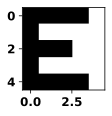

In [7]:
# generate 'E' pattern
pattern_E = np.array([1,1,1,1,-1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,-1,-1,-1,-1,1,1,1,1,-1]).reshape(25,1)
print(pattern_E.reshape(5,5))

plt.figure(figsize=(1.5,1.5))
plt.imshow(pattern_E.reshape(5,5), cmap = plt.cm.binary)

Text(0.5, 1.0, 'final state')

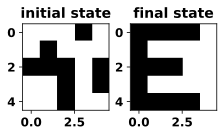

In [8]:
# generate connection weight
weight_matrix = np.matmul(pattern_E,pattern_E.T)/25
# print(weight_matrix)

np.random.seed(2) 
# if not fixing the seed of random numbers, sometimes in the final state
# the -1's and 1's are swapped because these two final states both lead to
# the same minimum energy according to $E(t)=-N\sum_{\mu}(m^\mu(t))^2$

# initial state
state = np.sign(np.random.randn(25))
fig,ax=plt.subplots(1,2, layout="constrained", figsize=(3,6))
ax[0].imshow(state.reshape(5,5), cmap = plt.cm.binary)
ax[0].set_title('initial state')

# One step for hopfield iteration
state = np.sign(np.matmul(weight_matrix,state))
ax[1].imshow(state.reshape(5,5), cmap = plt.cm.binary)
ax[1].set_title('final state')

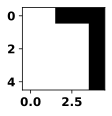

In [9]:
# generate '7' pattern
pattern_7 = np.array([-1,-1,1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,1]).reshape(25,1)

plt.figure(figsize=(1.5,1.5))
plt.imshow(pattern_7.reshape(5,5), cmap = plt.cm.binary)

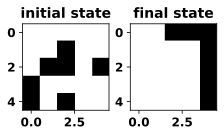

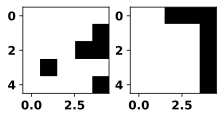

In [10]:
# generate connection weight
weight_matrix = np.matmul(pattern_7,pattern_7.T)/25

# initial state
state = np.array([-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1,1,1,-1,-1,-1,-1,1,-1,1,-1,-1])
fig,ax=plt.subplots(1,2, layout="constrained", figsize=(3,6))
ax[0].imshow(state.reshape(5,5), cmap = plt.cm.binary)
ax[0].set_title('initial state')

# One step for hopfield iteration
state = np.sign(np.matmul(weight_matrix,state))
ax[1].imshow(state.reshape(5,5), cmap = plt.cm.binary)
ax[1].set_title('final state')

# another initial state
state = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,1])
fig,ax=plt.subplots(1,2, layout="constrained", figsize=(3,6))
ax[0].imshow(state.reshape(5,5), cmap = plt.cm.binary)

# One step for hopfield iteration
state = np.sign(np.matmul(weight_matrix,state))
ax[1].imshow(state.reshape(5,5), cmap = plt.cm.binary)

---
# Summary

- This note includes several famous brain inspired models and algorithms in terms of their basic idea and how to use them in a specific task.
- MP model can be seen as the basic units in the modern artificial neural network. Although it is simple and only possess binary input and output, it can do some simple tasks such as binary classification.
- Hebb's rule are based on the biological fact of synaptic plasticity rule, it is an algorithm for unsupervised learning, which can recognize the structure in the data.
- Hopfield model is an abstract model of memory retrieval. After a cue with a partial overlap with one of the stored memory patterns is presented, the memory item is retrieved. Because the Hopfield model has symmetric synaptic connections, memory retrieval can be visualized as downhill movement in an energy landscape.

---